In [1]:
# Regular Modules
import numpy as np
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt
import datetime
import scipy.integrate as scint
from numpy.random import default_rng
import numpy.ma as ma
import matplotlib.tri as tri
import scipy.special as sc
import scipy.sparse as sps
import datetime

# My Modules
import src.helpers as helpers
import src.model_systems as model_systems
import src.diffusion_map as dmap

# Use timestamp for saving
time = datetime.datetime.now().strftime("%Y_%m%d_%H%M%S")
%matplotlib inline
plt.rcParams['figure.dpi'] = 75 # default is 75
plt.style.use('default')


### Load Full Molecular Dynamics Data for plotting
Trajectory has a *static* biased potential, computed from a well-tempered metadynamics run with biasing on a grid in $\phi,\psi$

In [2]:
fname='systems/aladip/data/TRAJ_COLVAR_METAD_2VAR_GRID'
colvar_data = np.loadtxt(fname)
end = colvar_data.shape[0]
start = 0 
step = 1    # Subsampling Rate
t = colvar_data[start:end:step,0]  # timestep
phi = colvar_data[start:end:step,1] # phi dihedral angle coordinates
psi = colvar_data[start:end:step,2] # psi dihedral angle coordinates
theta = colvar_data[start:end:step,3] # theta dihedral angle coordinates
xi = colvar_data[start:end:step,4] # xi dihedral angle coordinates

data = np.vstack([phi, psi])
N = data.shape[1]
print(f"number of data points: {N}")
print(f"data shape: {data.shape}")

number of data points: 50001
data shape: (2, 50001)


## Plot Molecular Dynamics Data

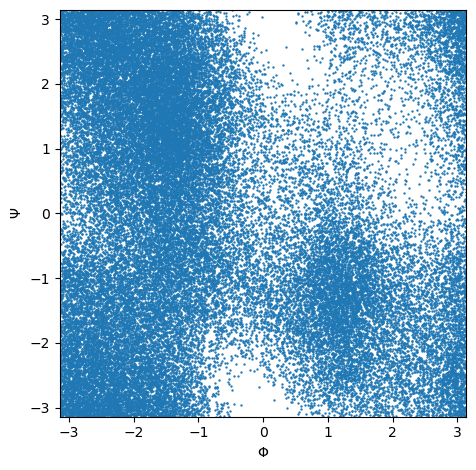

In [3]:
fig = plt.figure() 
plt.scatter(data[0, :], data[1, :], s=0.5)
xmin, xmax = -np.pi, np.pi
ymin, ymax = -np.pi, np.pi
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel(r'$\Phi$')
plt.ylabel(r'$\Psi$')
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')


### Plot Diffusion Tensors (2D, in $\phi$ and $\psi$)

Here we are subsampling data via kmeans clustering just to have some nicely spaced out ellipses.

/home/evansal/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


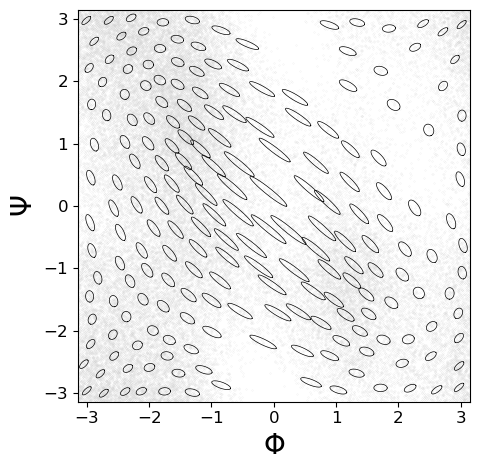

In [4]:
inData = np.load("systems/aladip/data/diffusions_traj_long_2var.npz")
diffusions_phipsi = inData["diffusions"]

plot_data = data[:, ::5]
plot_diffusions = diffusions_phipsi[::5, :, :]

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

fig = plt.figure() 
plt.scatter(data[0, :], data[1, :], s=0.01, color='lightgray')
plt.xlabel(r'$\Phi$', size=20)
plt.ylabel(r'$\Psi$', size=20)
xmin, xmax = -np.pi, np.pi
ymin, ymax = -np.pi, np.pi
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

# Use kmeans centroids as subsampled data for plotting ellipses
n_clusters = 200
kmeans = KMeans(n_clusters=n_clusters, random_state=1).fit(plot_data.T)
for i in range(n_clusters):
   idx = np.argmin(np.sum((plot_data.T - kmeans.cluster_centers_[i,:])**2,axis=1))
   C = plot_diffusions[idx, :, :]
   helpers.plot_cov_ellipse(C, plot_data[:, idx], plot_scale=0.3)
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()    


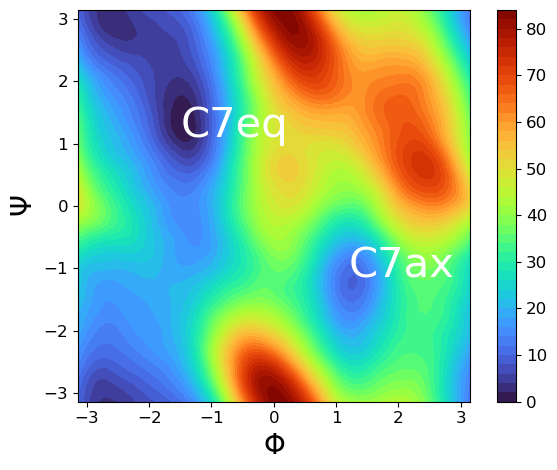

In [5]:
load_free_energy = np.loadtxt("systems/aladip/data/myfes.dat")
kb = 0.0083144621
T = 300
beta = 1.0 / (kb * T)

nx = 72
ny = 72
xmin = -np.pi
xmax = np.pi
ymin = xmin
ymax = xmax

hx = (xmax - xmin)/nx
hy = (ymax - ymin)/ny

x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
xx, yy = np.meshgrid(x, y)
zz = np.zeros_like(xx)
for i in range(nx):
    for j in range(ny):
        ind = int(i*nx + j)

        zz[i, j] = load_free_energy[ind, 2]

plt.gca().text(-1.5, 1.1, 'C7eq', fontsize=30, color='white')
plt.gca().text(1.2, -1.15, 'C7ax', fontsize=30, color='white')

plt.contourf(xx, yy, zz, 50, cmap='turbo')

plt.colorbar()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel(r'$\Phi$', size=20)
plt.ylabel(r'$\Psi$', size=20)
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')


# Load Data for Diffusion Maps

In [6]:
# Set Gromacs Temperature
kb = 0.0083144621
T = 300
beta = 1.0 / (kb * T)

#dataset = 'subsampled'
dataset = 'deltanet'
method = 'targetMMAP'

# Trajectory data
if dataset == 'subsampled':
    # Trajectory data
    fname = f"systems/aladip/data/wtmetad_phipsi_long_validation.npz"
    inData = np.load(fname)
    data = inData['data']
    diffusion_list = inData['diffusion_list']
    free_energy = inData['free_energy'].flatten()
    data = data[:, ::5]
    diffusion_list = diffusion_list[::5, :, :]
    free_energy = free_energy[::5]

if dataset == 'deltanet':
    fname = f"systems/aladip/data/wtmetad_phipsi_deltanet_validation.npz"
    inData = np.load(fname)
    data = inData['data']
    diffusion_list = inData['diffusion_list']
    free_energy = inData['free_energy'].flatten()

N = data.shape[1]
print("number of data points: %d" % N)

number of data points: 10000


## Set Reactant, Product Sets for Committor

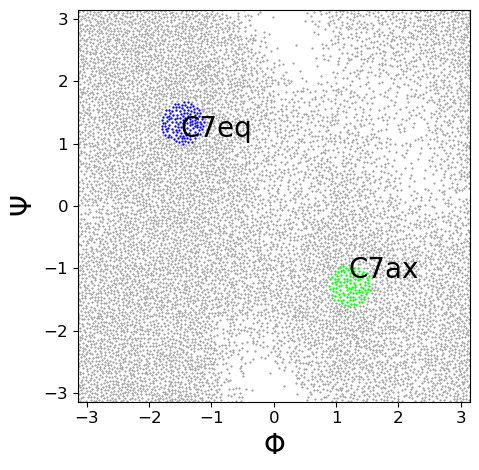

In [7]:
# Create boolean arrays defining A,B and rest of the domain (C)
A_bool = np.zeros(N, dtype=bool)
B_bool = np.zeros(N, dtype=bool)

# For setting, A,B based on circles
center_A = np.array([1.685966, 4.475022]) - np.pi
center_B = np.array([4.358306, 1.874166]) - np.pi
radius_A = 0.3490659
radius_B = 0.3490659


dist_A = np.sqrt(np.sum((center_A[..., np.newaxis] - data)**2, axis=0))
dist_B = np.sqrt(np.sum((center_B[..., np.newaxis] - data)**2, axis=0))
A_bool = dist_A < radius_A
B_bool = dist_B < radius_B 
C_bool = ~np.logical_or(A_bool, B_bool)

##################################################################################
A_plot = data[:, A_bool]
B_plot= data[:, B_bool]
C_plot = data[:, C_bool]

my_cmap = matplotlib.cm.get_cmap('brg')
A_color= my_cmap(0.0)
B_color = my_cmap(1.0)

fig = plt.figure() 
plt.scatter(A_plot[0, :], A_plot[1, :], s=0.5, color=A_color)
plt.scatter(B_plot[0, :], B_plot[1, :], s=0.5, color=B_color)
plt.scatter(C_plot[0, :], C_plot[1, :], s=0.2, color='gray')
plt.gca().text(-1.5, 1.1, 'C7eq', fontsize=20)
plt.gca().text(1.2, -1.15, 'C7ax', fontsize=20)

xmin, xmax = -np.pi, np.pi
ymin, ymax = -np.pi, np.pi
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel(r'$\Phi$', size=20)
plt.ylabel(r'$\Psi$', size=20)
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')


## Compute a Diffusion Map

In [8]:
eps = 0.01
pbc_dims = np.array([2*np.pi])
radius = None
n_neigh = 512
target_measure = np.exp(-beta*free_energy)
neigh_mode = "RNN"

##### Compute some sort of diffusion map 
if method == 'MMAP' or method == 'targetMMAP':
    if method == 'MMAP':
        target_measure = None
    my_dmap = dmap.TargetMeasureMahalanobisDiffusionMap(epsilon=eps, diffusion_list=diffusion_list,
                                                        radius=radius, n_neigh=n_neigh, neigh_mode=neigh_mode,
                                                        target_measure=target_measure,
                                                        remove_isolated=True, pbc_dims=pbc_dims)
   
if method == 'DMAP' or method =='targetDMAP':
    if method == 'DMAP':
        target_measure = None
    my_dmap = dmap.TargetMeasureDiffusionMap(epsilon=eps, radius=radius, n_neigh=n_neigh, 
                                            neigh_mode=neigh_mode, 
                                            target_measure=target_measure, 
                                            remove_isolated=True, pbc_dims=pbc_dims)
        
my_dmap.construct_generator(data)
q, subgraph  = my_dmap.construct_committor(B_bool, C_bool)
L = my_dmap.get_generator()

# Set `target measure` to kernel density estimate if not doing target measure dmap /mmap
if method == "DMAP" or method == "MMAP":
    target_measure = my_dmap.rho

# with radius nearest neighbors, some data points may be discarded, so we take the non-isolated ones
nonisolated_bool = subgraph["nonisolated_bool"] 
data_nonisolated = data[:, nonisolated_bool]

Computing Mahalanobis distance matrix
Computing RNN kernel
Number of nodes left after removing isolated: 10000
Ratio of nonzeros to zeros in kernel matrix: 0.00780784


In [9]:
##########################################################################
# Compute normalizing constant for dmap
##########################################################################
N = L.shape[0]
if method == 'targetMMAP':
    sqdists = my_dmap._compute_sqdists(data_nonisolated, metric=None)
else:
    sqdists = my_dmap._compute_sqdists(data_nonisolated)
sqdists = my_dmap._compute_nearest_neigh_graph(sqdists)
if sps.issparse(sqdists):
    K = sqdists.copy()
    K.data = np.exp(-K.data / (2*eps))
    # Check sparsity of kernel
    num_entries = K.shape[0]**2
    nonzeros_ratio = K.nnz / (num_entries)
    print(f"ratio of nonzeros: {nonzeros_ratio}")
    if nonzeros_ratio > 0.5:
        # Convert to dense matrix
        print("shifting to dense")
        #self.dense = True
        K = K.toarray()
else:
    K = np.exp(-sqdists / (2*eps))
K = K.minimum(K.T)

kde = np.array(K.sum(axis=1)).ravel()
kde = kde*(N*2*np.pi*eps)**(-1)

# correct the indexing of the target measure if necessary
if method == "DMAP" or method == "MMAP":
    target_measure_noniso = target_measure
else: 
    target_measure_noniso = target_measure[nonisolated_bool]

Z_dmap = (1/N)*np.sum(target_measure_noniso / kde)
print(f"approximate Z via dmaps: {Z_dmap}")


Computing RNN kernel
Number of nodes left after removing isolated: 10000
ratio of nonzeros: 0.02614276
approximate Z via dmaps: 0.6874401860627996


# Plot Committors

/tmp/ipykernel_3746/3932668287.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, ticks=C1.levels)


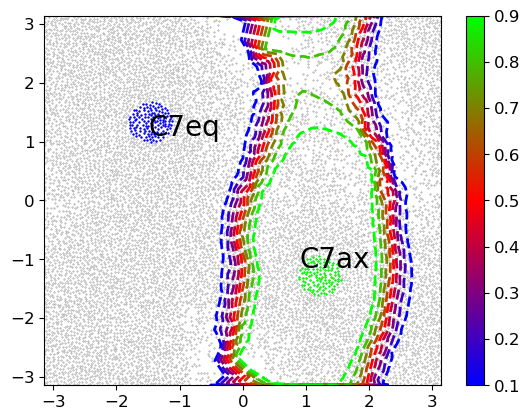

In [10]:
triang = tri.Triangulation(data_nonisolated[0, :], data_nonisolated[1, : ])

fig,ax = plt.subplots()
plt.scatter(data_nonisolated[0, :], data_nonisolated[1, :], s=0.1, color='gray')
my_levels = helpers.committor_contours()
cmap = 'brg'
C1=plt.tricontour(triang, q, levels=my_levels, linewidths=2.0, cmap=cmap, linestyles='dashed')
#plt.clabel(C1, C1.levels, fmt = '%0.1f', colors = 'k', fontsize=12) #contour line labels
norm= matplotlib.colors.Normalize(vmin=C1.cvalues.min(), vmax=C1.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap = C1.cmap)
sm.set_array([])
fig.colorbar(sm, ticks=C1.levels)

plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.gca().text(-1.5, 1.1, 'C7eq', fontsize=20)
plt.gca().text(0.9, -1.15, 'C7ax', fontsize=20)

my_cmap = matplotlib.cm.get_cmap('brg')
A_color= my_cmap(0.0)
B_color = my_cmap(1.0)

plt.scatter(A_plot[0, :], A_plot[1, :], s=0.5, color=A_color)
plt.scatter(B_plot[0, :], B_plot[1, :], s=0.5, color=B_color)



### Compute Reactive Current in $\Phi, \Psi$ dihedrals

In [11]:
pbc_dims = np.array([2*np.pi])
if sps.issparse(L):
    L = L.toarray()
target_measure = target_measure.flatten()
current_x = (1/(Z_dmap*beta))*target_measure_noniso*(helpers.duchamp(L, q, data[0, nonisolated_bool], PBC_ARG2=True, pbc_dims=pbc_dims)).flatten()
current_y = (1/(Z_dmap*beta))*target_measure_noniso*(helpers.duchamp(L, q, data[1, nonisolated_bool], PBC_ARG2=True, pbc_dims=pbc_dims)).flatten()
current = np.vstack([current_x, current_y])

### Plot Reactive Current

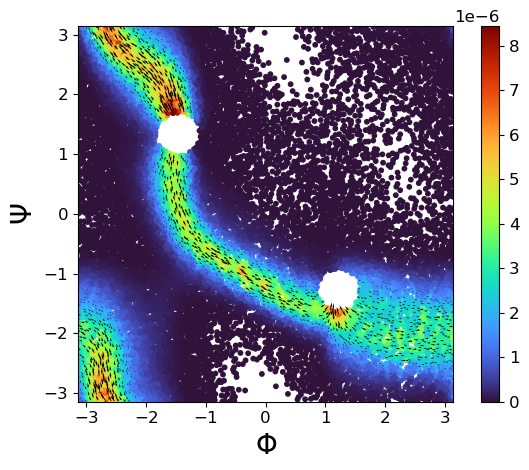

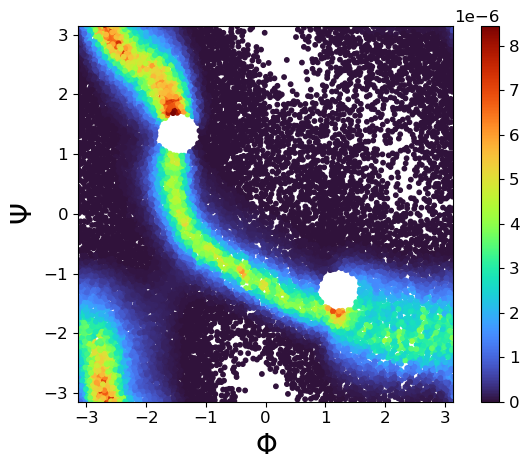

In [12]:
# Current isn't defined on A or B
C_bool_nonisolated = C_bool[nonisolated_bool]
plot_data = data_nonisolated[:, C_bool_nonisolated]
plot_current = current[:, C_bool_nonisolated]
curr_mag = np.sqrt(current[0, :]**2 + current[1, :]**2)
plot_curr_mag = np.sqrt(plot_current[0, :]**2 + plot_current[1, :]**2)

plt.figure() 

cmap = 'turbo'
plt.scatter(plot_data[0, :], plot_data[1, :], s=10.0, c=plot_curr_mag, cmap=cmap)
plt.colorbar()
plt.quiver(plot_data[0, ::2], plot_data[1, ::2], plot_current[0, ::2], plot_current[1, ::2], angles='xy', scale_units='xy', scale=0.00005, minlength=0, headwidth=2)
#plt.quiver(plot_data[0, :], plot_data[1, :], plot_current[0, :], plot_current[1, :], angles='xy', scale = 100, minlength=0, headwidth=2)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel(r'$\Phi$', size=20)
plt.ylabel(r'$\Psi$', size=20)
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')

plt.figure()
plt.scatter(plot_data[0, :], plot_data[1, :], s=10.0, c=plot_curr_mag, cmap=cmap)
plt.colorbar()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel(r'$\Phi$', size=20)
plt.ylabel(r'$\Psi$', size=20)

plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')

